In [ ]:
# 2025/01/17
# I'm not yet sure if I want this in the github
# but this is related to some older code for adding some 
# named crops for different samples

In [67]:
import os
from matplotlib import pyplot as plt
import torch 

from filmscope.recon_util import get_all_sample_names, get_sample_information, get_ss_volume_from_dataset, add_individual_crop
from filmscope.calibration import CalibrationInfoManager
from filmscope.config import path_to_data
from filmscope.util import load_image_set, play_video
from filmscope.datasets import FSDataset

In [68]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [69]:
get_all_sample_names()

['fluoro_bright', 'fluoro_bright_calib2']

In [87]:
sample_name = "fluoro_bright_calib2"
new_crop_name = "fluoro_patch"
sample_info = get_sample_information(sample_name)

manager = CalibrationInfoManager(path_to_data + sample_info["calibration_filename"])
ref_img = manager.reference_camera
image = load_image_set(path_to_data + sample_info["image_filename"], image_numbers=[ref_img])[ref_img]

loading images: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


(2700.0, 1700.0)

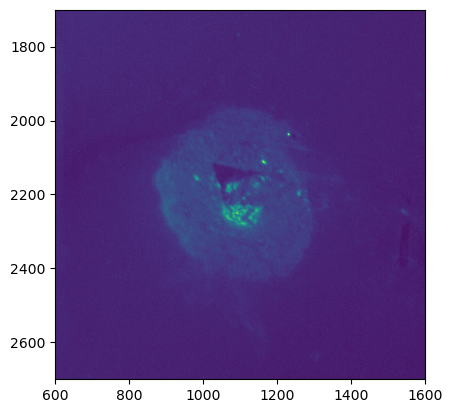

In [89]:
crop_pixels = (1700, 2700, 600, 1600)
plt.imshow(image)
ax = plt.gca() 
ax.set_xlim(crop_pixels[2], crop_pixels[3])
ax.set_ylim(crop_pixels[1], crop_pixels[0])

In [90]:
crop_values = (
    crop_pixels[0] / image.shape[0],
    crop_pixels[1] / image.shape[0],
    crop_pixels[2] / image.shape[1],
    crop_pixels[3] / image.shape[1],
)

ref_crop_center = (
    (crop_values[1] + crop_values[0]) / 2,
    (crop_values[3] + crop_values[2]) / 2,
)
crop_size = ((crop_values[1] - crop_values[0]), (crop_values[3] - crop_values[2]))

downsample = 4
image_numbers = manager.image_numbers
dataset = FSDataset(
    path_to_data + sample_info["image_filename"],
    path_to_data + sample_info["calibration_filename"],
    image_numbers,
    downsample,
    crop_values,
    enforce_divisible=-1,
    # TODO: adjust these to handle datasets with frames and blank files
    frame_number=-1,
    blank_filename=None 
)

loading images: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


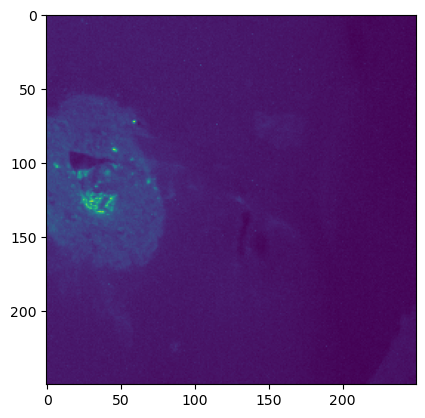

In [91]:
plt.imshow(dataset.images[2].squeeze())

In [92]:
# now we'll decide on height range and estimated height
low = 0
high = 3
num = 30

depths = torch.linspace(low, high, num, dtype=torch.float32).cuda()

batch_size = 10
volume = get_ss_volume_from_dataset(dataset, batch_size, depths, get_squared=False)
volume = volume.squeeze().cpu().numpy()

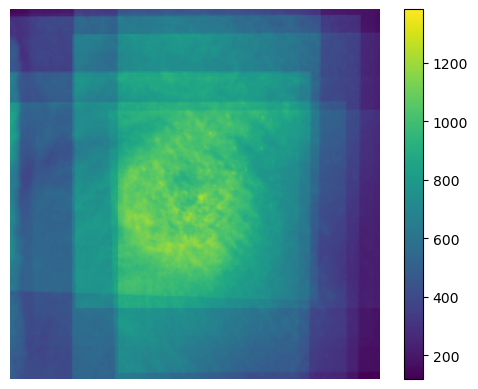

In [93]:
play_video(volume)

Text(0.5, 1.0, '0.00 mm')

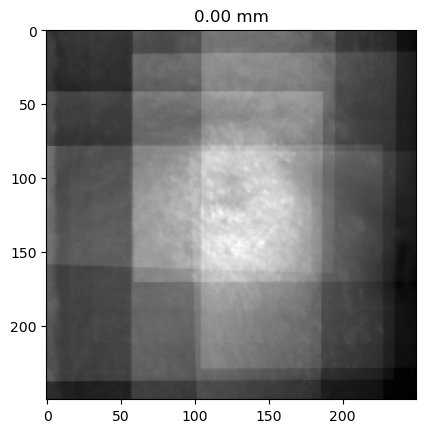

In [94]:
idx = 0
plt.imshow(volume[idx], cmap='gray')
plt.title("{:.2f} mm".format(depths[idx]))

In [95]:
height_est = (high + low) / 2

crop_info, entry_number = add_individual_crop(
    sample_name,
    new_crop_name,
    save=True,
    depth_range=(low, high),
    height_est=height_est,
    ref_crop_center=ref_crop_center,
    crop_size=crop_size,
)